In [1]:
from __future__ import division
from __future__ import print_function

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import numpy as np
import cv2

from hourglass import hg
from dataset import *


In [2]:
#creating datasets
def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler,num_workers=4)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler,num_workers=4)
    
    return train_loader, valid_loader

In [15]:
t = ToolDataset(csv_file='data/annotations_2c.csv',root_dir='data/ins_images')
s = t[60]
s['landmarks']
scale = Rescale((256,256))
loc = LocsToHeatmaps()
s_t = scale(s)
s_t = loc(s_t)

hm =s_t['keypoint_heatmaps']
im = s_t['image']

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


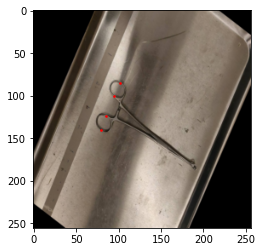

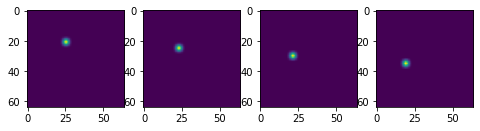

In [16]:
show_landmarks(im,s_t['landmarks'])

fig=plt.figure(figsize=(8, 8))
for i in range(4):
    img = hm[:,:,i]
    fig.add_subplot(1, 4, i+1)
    plt.imshow(img)
plt.show()

In [10]:
class Trainer(object):

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_transform_list = [Rescale((256,256)),LocsToHeatmaps(out_size=(64, 64)),ToTensor()]
        self.train_ds = ToolDataset(csv_file='data/annotations_2c.csv',root_dir='data/ins_images',transform=transforms.Compose(train_transform_list))
        self.model = hg(num_stacks=1, num_blocks=1, num_classes=4).to(self.device,dtype=torch.float)

        # define loss function and optimizer
        self.heatmap_loss = torch.nn.MSELoss().to(self.device,dtype=torch.float) # for Global loss
        self.optimizer = torch.optim.RMSprop(self.model.parameters(),
                                             lr = 2.5e-4)
        self.train_data_loader = DataLoader(self.train_ds, batch_size=16,num_workers=4,pin_memory=True,shuffle=True)


        self.summary_iters = []
        self.losses = []
        self.pcks = []

    def train(self):
        self.total_step_count = 0
        train_loss =0
        
        for epoch in range(1,400+1):
            train_loss =0

            print("Epoch %d/%d"%(epoch,400))

            for step, batch in enumerate(self.train_data_loader):
                self.model.train()
                batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                self.optimizer.zero_grad()
                pred_heatmap_list = self.model(batch['image'].to(self.device,dtype=torch.float))
                loss = self.heatmap_loss(pred_heatmap_list[-1], batch['keypoint_heatmaps'].to(self.device,dtype=torch.float))
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()*batch['image'].size(0)
                
                self.total_step_count += 1
            
            train_loss = np.sqrt(train_loss/self.train_data_loader.sampler.num_samples)
            print(train_loss)


        checkpoint = {'model': self.model.state_dict()}
        torch.save(checkpoint, 'model_2c.pt')

In [11]:
trainer = Trainer()
trainer.train()

Epoch 1/400
0.12265031728062216
Epoch 2/400


KeyboardInterrupt: 

In [16]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

